In [6]:
# Environ
import scipy as scp
import tensorflow as tf
from scipy.stats import gamma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import random
import multiprocessing as mp
import psutil
import pickle
import os
import re


# import dataset_generator as dg
# import make_data_lba as mdlba
# from tqdm import tqdm

# Own
import ddm_data_simulation as ds
import cddm_data_simulation as cds
import kde_training_utilities as kde_util
import kde_class as kde
import boundary_functions as bf

In [ ]:
# DDM  
repeats = 1
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.ddm_flexbound(v = 0, 
                            a = 0.96,
                            w = 0.5,
                            ndt = 0.5,
                            delta_t = 0.01, 
                            max_t = 20,
                            n_samples = 20000,
                            boundary_fun = bf.weibull_cdf,
                            boundary_multiplicative = False, 
                            boundary_params = {'a': 1, 'beta': 2})
                            #boundary_params = {"theta": 0.01})
    print(i)
    
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
def bin_simulator_output(out = [0, 0],
                         bin_dt = 0.04,
                         n_bins = 0,
                         eps_correction = 1e-7, # min p for a bin
                         params = ['v', 'a', 'w', 'ndt']
                        ): # ['v', 'a', 'w', 'ndt', 'angle']

    # Generate bins
    if n_bins == 0:
        n_bins = int(out[2]['max_t'] / bin_dt)
        bins = np.linspace(0, out[2]['max_t'], n_bins)
    else:    
        bins = np.linspace(0, out[2]['max_t'], n_bins)
        bins = np.append(bins, [100])
        print(bins)
    counts = []
    cnt = 0
    counts = np.zeros( (n_bins, len(out[2]['possible_choices']) ) )
    counts_size = counts.shape[0] * counts.shape[1]
    
    for choice in out[2]['possible_choices']:
        counts[:, cnt] = np.histogram(out[0][out[1] == choice], bins = bins)[0] / out[2]['n_samples']
        cnt += 1
    
    # Apply correction for empty bins
    n_small = 0
    n_big = 0
    n_small = np.sum(counts < eps_correction)
    n_big = counts_size - n_small 
    
    if eps_correction > 0:
        counts[counts <= eps_correction] = eps_correction
        counts[counts > eps_correction] -= (eps_correction * (n_small / n_big))

    return ([out[2][param] for param in params], # features
            counts, # labels
            {'max_t': out[2]['max_t'], 
             'bin_dt': bin_dt, 
             'n_samples': out[2]['n_samples']} # meta data
           )

In [ ]:
#%%timeit -n 1 -r 5
a, b = bin_simulator_output(out = out)

In [184]:
%%timeit -n 5 -r 1
out = cds.ornstein_uhlenbeck(v = 0.0,
                             a = 1.5,
                             w = 0.5,
                             g = 0,
                             ndt = 0.92,
                             delta_t = 0.001,
                             boundary_fun = bf.constant,
                             n_samples = 100000)

36.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [ ]:
binned_sims = bin_simulator_output(out = out,
                                   n_bins = 256,
                                   eps_correction = 1e-7,
                                   params = ['v', 'a', 'w', 'g', 'ndt'])

In [181]:
%%timeit -n 5 -r 1
out = cds.ddm_flexbound_seq2(v_h = 0,
                             v_l_1 = 0,
                             v_l_2 = 0,
                             a = 1.5,
                             w_h = 0.5,
                             w_l_1 = 0.5,
                             w_l_2 = 0.5,
                             ndt = 0.5,
                             s = 1,
                             delta_t = 0.001,
                             max_t = 20,
                             n_samples = 100000,
                             print_info = True,
                             boundary_fun = bf.constant, # function of t (and potentially other parameters) that takes in (t, *args)
                             boundary_multiplicative = True,
                             boundary_params = {})

1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [180]:
%%timeit -n 5 -r 1
out = cds.ddm_flexbound_par2(v_h = 0,
                             v_l_1 = 0,
                             v_l_2 = 0,
                             a = 1.5,
                             w_h = 0.5,
                             w_l_1 = 0.5,
                             w_l_2 = 0.5,
                             ndt = 0.5,
                             s = 1,
                             delta_t = 0.001,
                             max_t = 20,
                             n_samples = 100000,
                             print_info = True,
                             boundary_fun = bf.constant, # function of t (and potentially other parameters) that takes in (t, *args)
                             boundary_multiplicative = True,
                             boundary_params = {})

1min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [178]:
%%timeit -n 5 -r 1 
out = cds.ddm_flexbound_mic2(v_h = 0.0,
                             v_l_1 = 0.0,
                             v_l_2 = 0.0,
                             a = 1.5,
                             w_h = 0.5,
                             w_l_1 = 0.5,
                             w_l_2 = 0.5,
                             d = 1.0, 
                             ndt = 0.5,
                             s = 1,
                             delta_t = 0.001,
                             max_t = 20,
                             n_samples = 100000,
                             print_info = True,
                             boundary_fun = bf.constant, # function of t (and potentially other parameters) that takes in (t, *args)
                             boundary_multiplicative = True,
                             boundary_params = {})

1min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   7.,
         18.,  24.,  26.,  40.,  37.,  66.,  79.,  82., 116., 115., 119.,
        143., 166., 179., 176., 189., 203., 195., 217., 215., 239., 208.,
        218., 233., 240., 232., 230., 252., 264., 254., 271., 283., 275.,
        280., 270., 266., 283., 282., 293., 246., 250., 252., 273., 276.,
        261., 263., 265., 236., 250., 279., 216., 248., 220., 240., 232.,
        221., 246., 231., 213., 218., 214., 210., 196., 230., 202., 205.,
        195., 222., 216., 185., 183., 161., 177., 188., 173., 177., 174.,
        176., 166., 172., 176., 161., 158., 149., 158., 138., 185., 148.,
        140., 145., 156., 139., 129., 130., 105., 119., 141., 104., 116.,
        112., 121., 106., 117., 109.,  96.,  95.,  93., 116., 110.,  99.,
         97.,  88.,  96.,  88.,  93.,  84.,  80.,  77.,  86.,  71.,  73.,
         88.,  70.,  81.,  91.,  68., 

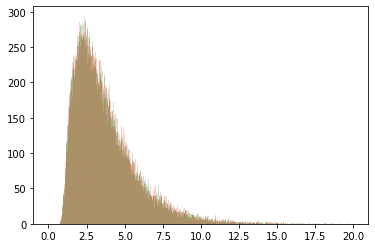

In [179]:
plt.hist(out[0][out[1][:, 0] == 0, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'red')
plt.hist(out[0][out[1][:, 0] == 1, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'green')
plt.hist(out[0][out[1][:, 0] == 2, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'red')
plt.hist(out[0][out[1][:, 0] == 3, 0], bins = np.arange(512) * 20/512 , alpha = 0.2, color = 'green')

In [185]:
import pickle
import os


In [188]:
os.listdir('/media/data_cifs/afengler/data/kde/ddm_seq2/training_data_binned_1_nbins_512_n_100000')

['ddm_seq2_nchoices_2_train_data_binned_1_nbins_512_n_100000_999.pickle']

In [211]:
tt = pickle.load(open('/media/data_cifs/afengler/data/kde/ddm_mic2/training_data_binned_1_nbins_512_n_100000/ddm_mic2_nchoices_2_train_data_binned_1_nbins_512_n_100000_999.pickle', 'rb'))

In [195]:
tt[1][0][:,0]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e-05, 2.300e-04,
       7.500e-04, 1.630e-03, 2.620e-03, 3.470e-03, 5.330e-03, 5.970e-03,
       7.820e-03, 8.140e-03, 9.420e-03, 9.680e-03, 1.008e-02, 1.038e-02,
       1.083e-02, 1.139e-02, 1.050e-02, 1.050e-02, 1.000e-02, 1.021e-02,
       9.690e-03, 9.210e-03, 8.560e-03, 8.420e-03, 7.900e-03, 6.960e-03,
       6.720e-03, 6.960e-03, 6.690e-03, 6.050e-03, 5.490e-03, 5.400e-03,
       5.210e-03, 4.600e-03, 4.820e-03, 4.620e-03, 4.070e-03, 3.630e-03,
       3.420e-03, 2.790e-03, 3.010e-03, 3.260e-03, 2.740e-03, 2.280e-03,
       2.180e-03, 2.040e-03, 1.880e-03, 1.860e-03, 1.610e-03, 1.450e-03,
       1.450e-03, 1.540e-03, 1.210e-03, 1.060e-03, 1.100e-03, 1.100e-03,
       1.040e-03, 1.060e-03, 7.500e-04, 8.500e-04, 

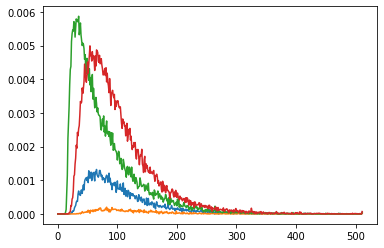

In [215]:
plt.plot(tt[1][2, :,0])
plt.plot(tt[1][2, :,1])
plt.plot(tt[1][2, :,2])
plt.plot(tt[1][2, :,3])

In [145]:
print(np.mean(out[0][out[1][:, 0] == 0, 0]))
print(np.mean(out[0][out[1][:, 0] == 1, 0]))
#print(np.mean(out[0][out[1][:, 0] == 2, 0]))
#print(np.mean(out[0][out[1][:, 0] == 3, 0]))

1.9529729
1.9603328


In [146]:
print(np.shape(out[0][out[1][:, 0] == 0, 0]))
print(np.shape(out[0][out[1][:, 0] == 1, 0]))
#print(np.shape(out[0][out[1][:, 0] == 2, 0]))
#print(np.shape(out[0][out[1][:, 0] == 3, 0]))

(24981,)
(24776,)


In [143]:
np.sort(out[0][out[1][:,0] == 1, 0])

array([ 0.6530001,  0.6530001,  0.6530001, ...,  9.054827 ,  9.446985 ,
       13.031434 ], dtype=float32)

(array([5.660e+02, 2.480e+03, 3.954e+03, 4.277e+03, 4.152e+03, 3.769e+03,
        3.262e+03, 2.780e+03, 2.322e+03, 1.880e+03, 1.455e+03, 1.157e+03,
        9.380e+02, 7.480e+02, 5.870e+02, 4.720e+02, 3.540e+02, 2.990e+02,
        2.170e+02, 1.910e+02, 1.350e+02, 1.160e+02, 7.500e+01, 8.600e+01,
        6.700e+01, 4.800e+01, 2.800e+01, 4.000e+01, 2.600e+01, 1.200e+01,
        1.100e+01, 1.000e+01, 7.000e+00, 8.000e+00, 1.000e+01, 4.000e+00,
        5.000e+00, 5.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.7490003,  1.0663557,  1.3837112,  1.7010666,  2.0184221,
         2.3357775,  2.653133 ,  2.9704883,  3.2878437,  3.605199 ,
         3.9225545,  4.23991  ,  4.5572653,  4.874621 ,  5.191976 ,
         5.5093317,  5.8266873,  6.1440425,  6.461398 ,  6.7787533,
         7.096109 ,  7.413464 ,  7.7308197,  8.048175 ,  8.365531 ,
         8.682886 ,  9.000241 ,  9.3

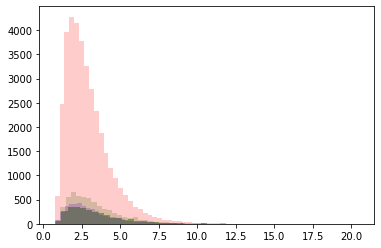

In [121]:
plt.hist(out[0][out[1][:, 0] == 0, 0], bins = 50, alpha = 0.5, color = 'green')
plt.hist(out[0][out[1][:, 0] == 1, 0], bins = 50, alpha = 0.2, color = 'green')
plt.hist(out[0][out[1][:, 0] == 2, 0], bins = 50, alpha = 0.2, color = 'blue')
plt.hist(out[0][out[1][:, 0] == 3, 0], bins = 50, alpha = 0.2, color = 'red')

In [122]:
print(np.max(out[0][out[1][:, 0] == 0, 0]))
print(np.max(out[0][out[1][:, 0] == 1, 0]))
print(np.max(out[0][out[1][:, 0] == 2, 0]))
print(np.max(out[0][out[1][:, 0] == 3, 0]))

20.500637
17.52927
14.810153
16.616772


In [ ]:
binned_sims = bin_simulator_output(out = out,
                                   n_bins = 256,
                                   eps_correction = 1e-7,
                                   params = ['v', 'a', 'w', 'g', 'ndt'])

In [ ]:
plt.plot(binned_sims[1][:, 1])
plt.plot(binned_sims[1][:, 0])

In [ ]:
binned_sims[1][255, 1]

In [ ]:
files_ = os.listdir('/media/data_cifs/afengler/data/kde/ddm/base_simulations_20000')

In [ ]:
labels = np.zeros((250000, 500, 2))
features = np.zeros((250000, 3))

cnt = 0
i = 0
file_dim = 100
for file_ in files_[:1000]:
    if file_[:8] == 'ddm_flex':
        out = pickle.load(open('/media/data_cifs/afengler/data/kde/ddm/base_simulations_20000/' + file_, 'rb'))
        features[cnt], labels[cnt] = bin_simulator_output(out = out)
        if cnt % file_dim == 0:
            print(cnt)
            pickle.dump((labels[(i * file_dim):((i + 1) * file_dim)], features[(i * file_dim):((i + 1) * file_dim)]), open('/media/data_cifs/afengler/data/kde/ddm/base_simulations_20000_binned/dataset_' + str(i), 'wb'))
            i += 1
        cnt += 1


In [ ]:
# FULL DDM  
repeats = 50
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.full_ddm(v = 0, 
                       a = 0.96,
                       w = 0.5,
                       ndt = 0.5,
                       dw = 0.0,
                       sdv = 0.0,
                       dndt = 0.5,
                       delta_t = 0.01, 
                       max_t = 20,
                       n_samples = 10000,
                       boundary_fun = bf.constant,
                       boundary_multiplicative = True, 
                       boundary_params = {})
    print(i)
    
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
plt.hist(out[0] * out[1], bins = 50)

In [ ]:
int(50 / out[2]['delta_t'] + 1)

In [ ]:
# LCA 
repeats = 1
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.lca(v = np.array([0, 0], dtype = np.float32), 
                  a = 2, 
                  w = np.array([0.5, 0.5], dtype = np.float32), 
                  ndt = np.array([1.0, 1.0], dtype = np.float32),
                  g = -1.0,
                  b = 1.0,
                  delta_t = 0.01, 
                  max_t = 40,
                  n_samples = 10000,
                  boundary_fun = bf.constant,
                  boundary_multiplicative = True, 
                  boundary_params = {})
    print(i)
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
out[1][out[1] == 0] = -1
plt.hist(out[0] * out[1], bins = 50)

In [ ]:
# LCA 
repeats = 10
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.ddm_flexbound(v = 0.0, 
                            a = 1.5, 
                            w = 0.5, 
                            ndt = 0.1,
                            delta_t = 0.01, 
                            max_t = 40,
                            n_samples = 10000,
                            boundary_fun = bf.constant,
                            boundary_multiplicative = True, 
                            boundary_params = {})
    print(i)
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
def foo(name, *args, **kwargs):
    print ("args: ", args)
    print ("Type of args: ", type(args))
    if len(args)>2:
        args = args[0], args[1]     #- Created Same name variable.
    print ("Temp args:", args)

In [ ]:
my_keys = []
for key in test_dat.keys():
    if key[0] == 'v':
        my_keys.append(key)
np.array(test_dat.loc[1, ['v_0', 'v_1']])

In [ ]:
my_dat = mdlba.make_data_rt_choice(target_folder = my_target_folder)

In [ ]:
np.max(my_dat['log_likelihood'])

In [ ]:
data = np.concatenate([out[0], out[1]], axis = 1)

In [ ]:
###
cds.race_model(boundary_fun = bf.constant,
              n_samples = 100000)

In [ ]:
np.quantile(np.random.uniform(size = (10000,4)), q = [0.05, 0.10, 0.9, 0.95], axis = 0)

In [ ]:
tuple(map(tuple, a))

In [ ]:
tuple(np.apply_along_axis(my_func, 0, a, key_vec))

In [ ]:
dict(zip(a[0,:], ['a' ,'b', 'c']))

In [ ]:
def my_func(x = 0, key_vec = ['a' ,'b', 'c']):
    return dict(zip(key_vec, x))

In [ ]:
my_func_init = my_func(key_vec = ['d', 'e', 'f'])

In [ ]:
test = yaml.load(open('config_files/config_data_generator.yaml'))

In [22]:
from multiprocessing import Pool

def myfunc(a):
    return a ** 2
pbar = tqdm(total = 100)
def update():
    pbar.update

a = tuple()
for i in range(pbar.total):
    a += ((1, ), )
    
pool = Pool(4)
pool.starmap(myfunc, a, callback = update)
pool.close()
pool.join()






  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: starmap() got an unexpected keyword argument 'callback'

In [ ]:
def my_fun(*args):
    print(args)

In [ ]:
help(dg.make_dataset_r_dgp)

In [ ]:
def zip_dict(x = [], 
             key_vec = ['a', 'b', 'c']):
    return dict(zip(key_vec, x))

In [ ]:
my_dg = dg.data_generator(file_id = 'TEST')

In [ ]:
out = my_dg.make_dataset_perturbation_experiment(save = False)

In [ ]:
out = my_dg.make_dataset_uniform(save = False)

In [ ]:
my_dg.param_grid_perturbation_experiment()

In [ ]:
param_grid = my_dg.param_grid_uniform()

In [ ]:
%%timeit -n 1 -r 1
tt = my_dg.generate_data_grid_parallel(param_grid = param_grid)

In [ ]:
my_dg.config

In [ ]:
a = np.random.choice(10, size = (1000,1))

In [25]:
for i in zip([1,2,3], [1, 2, 3], [1]):
    print( i )

(1, 1, 1)
